In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load individual day files for the ISCXIDS2012 dataset
saturday_data = pd.read_xml(r"/home/kali/Documents/telecom/exo5/ISCXIDS2012 dataset/labeled_flows_xml/TestbedSatJun12Flows.xml")
sunday_data = pd.read_xml(r"/home/kali/Documents/telecom/exo5/ISCXIDS2012 dataset/labeled_flows_xml/TestbedSunJun13Flows.xml")
monday_data = pd.read_xml(r"/home/kali/Documents/telecom/exo5/ISCXIDS2012 dataset/labeled_flows_xml/TestbedMonJun14Flows.xml")
tuesday1_data = pd.read_xml(r"/home/kali/Documents/telecom/exo5/ISCXIDS2012 dataset/labeled_flows_xml/TestbedTueJun15-1Flows.xml")

wednesday1_data = pd.read_xml(r"/home/kali/Documents/telecom/exo5/ISCXIDS2012 dataset/labeled_flows_xml/TestbedWedJun16-1Flows.xml")

thursday2_data = pd.read_xml(r"/home/kali/Documents/telecom/exo5/ISCXIDS2012 dataset/labeled_flows_xml/TestbedThuJun17-2Flows.xml")


# Combine Tuesday and Wednesday datasets
tuesday_data = pd.concat([tuesday1_data], ignore_index=True)
wednesday_data = pd.concat([wednesday1_data], ignore_index=True)
thursday_data = pd.concat([thursday2_data], ignore_index=True)

# Store dataframes and their respective labels
weekly_data = [saturday_data, sunday_data, monday_data, tuesday_data, wednesday_data, thursday_data]
week_days = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday']

# Initialize list to store merged data
merged_data = []

# Loop through each day, adding a 'Tag' column and appending the data
for day_data, day_label in zip(weekly_data, week_days):
    day_data['Tag'] = day_label
    print(day_data.info())  # Optional: Print info of each day's dataset
    merged_data.append(day_data)

# Concatenate all data into a single DataFrame
final_data = pd.concat(merged_data, ignore_index=True)

# Display the first few rows of the final merged DataFrame
print(final_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133193 entries, 0 to 133192
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   appName                         133193 non-null  object
 1   totalSourceBytes                133193 non-null  int64 
 2   totalDestinationBytes           133193 non-null  int64 
 3   totalDestinationPackets         133193 non-null  int64 
 4   totalSourcePackets              133193 non-null  int64 
 5   sourcePayloadAsBase64           70040 non-null   object
 6   sourcePayloadAsUTF              70040 non-null   object
 7   destinationPayloadAsBase64      68042 non-null   object
 8   destinationPayloadAsUTF         68041 non-null   object
 9   direction                       133193 non-null  object
 10  sourceTCPFlagsDescription       94981 non-null   object
 11  destinationTCPFlagsDescription  90822 non-null   object
 12  source                        

In [3]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
X = final_data[['totalSourceBytes', 'totalDestinationBytes', 'totalDestinationPackets', 'totalSourcePackets', 'sourcePort', 'destinationPort']]
Y = final_data[['Tag']]
Y = labelencoder.fit_transform(Y)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold

clf = DecisionTreeRegressor(random_state=0)
clf.fit(X_train, Y_train)
predictions = clf.predict(X_test)
rounded_predictions = np.round(predictions).astype(int)
predicted_days = labelencoder.inverse_transform(rounded_predictions)

cv = KFold(n_splits=10, random_state=0, shuffle=True)
cv_scores = cross_val_score(clf, X_train, Y_train, scoring='r2', cv=cv, n_jobs=-1)
print(f"Cross-validated R^2 scores: {cv_scores.mean()}")

from sklearn.metrics import mean_squared_error, r2_score

predict = clf.predict(X_test)
mse = mean_squared_error(Y_test, predict)
r2 = r2_score(Y_test, predict)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

/home/kali/Documents/telecom/.telecom/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-validated R^2 scores: -0.13180316441219608
Mean Squared Error: 3.079543039908962
R^2 Score: -0.1159030204935183


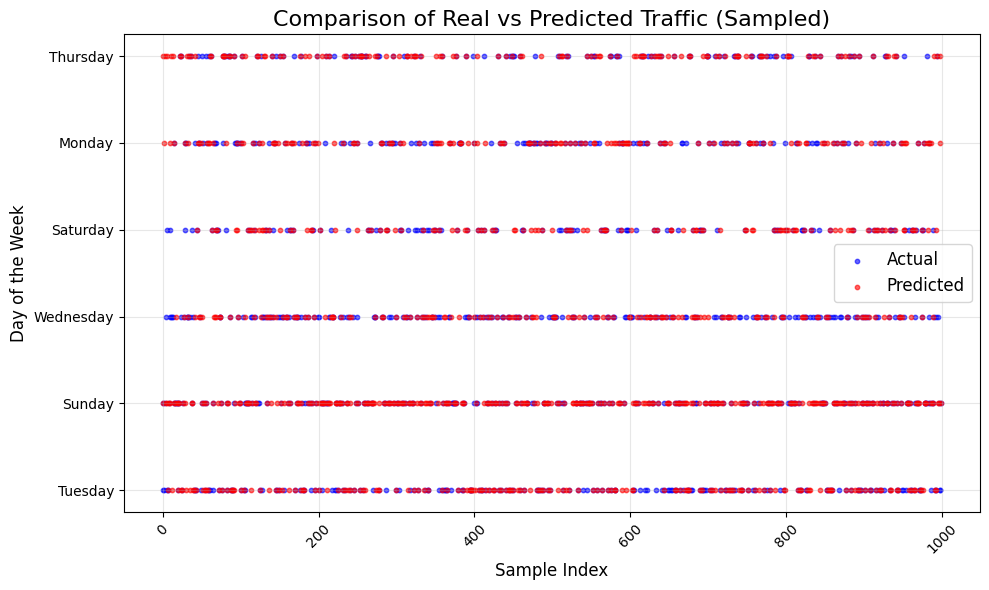

In [4]:
import random 

sample_size = 1000
indices = random.sample(range(len(Y_test)), k=sample_size)
Y_test_sample = [labelencoder.inverse_transform([Y_test[i]])[0] for i in indices]
predict_sample = [predicted_days[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.scatter(range(sample_size), Y_test_sample, color='blue', label='Actual', alpha=0.6, s=10)
plt.scatter(range(sample_size), predict_sample, color='red', label='Predicted', alpha=0.6, s=10)
plt.title('Comparison of Real vs Predicted Traffic (Sampled)', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Day of the Week', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the regressors
rf_regressor = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
ada_regressor = AdaBoostRegressor(n_estimators=200, random_state=42)

# Train the RandomForestRegressor
rf_regressor.fit(X_train, Y_train)
rf_predictions = rf_regressor.predict(X_test)
rf_rounded_predictions = np.round(rf_predictions).astype(int)
rf_predicted_days = labelencoder.inverse_transform(rf_rounded_predictions)

# Train the AdaBoostRegressor
ada_regressor.fit(X_train, Y_train)
ada_predictions = ada_regressor.predict(X_test)
ada_rounded_predictions = np.round(ada_predictions).astype(int)
ada_predicted_days = labelencoder.inverse_transform(ada_rounded_predictions)

# Evaluate RandomForestRegressor
rf_mse = mean_squared_error(Y_test, rf_predictions)
rf_r2 = r2_score(Y_test, rf_predictions)
print(f"RandomForestRegressor Mean Squared Error: {rf_mse}")
print(f"RandomForestRegressor R^2 Score: {rf_r2}")

# Evaluate AdaBoostRegressor
ada_mse = mean_squared_error(Y_test, ada_predictions)
ada_r2 = r2_score(Y_test, ada_predictions)
print(f"AdaBoostRegressor Mean Squared Error: {ada_mse}")
print(f"AdaBoostRegressor R^2 Score: {ada_r2}")

# Choose the best model based on R^2 score
if rf_r2 > ada_r2:
    best_model = rf_regressor
    best_predictions = rf_predictions
    best_predicted_days = rf_predicted_days
    print("RandomForestRegressor is the best model.")
else:
    best_model = ada_regressor
    best_predictions = ada_predictions
    best_predicted_days = ada_predicted_days
    print("AdaBoostRegressor is the best model.")

# Compare with the results from DecisionTreeRegressor
dt_mse = mean_squared_error(Y_test, predictions)
dt_r2 = r2_score(Y_test, predictions)
print(f"DecisionTreeRegressor Mean Squared Error: {dt_mse}")
print(f"DecisionTreeRegressor R^2 Score: {dt_r2}")

# Print the best model's performance
print(f"Best Model Mean Squared Error: {mean_squared_error(Y_test, best_predictions)}")
print(f"Best Model R^2 Score: {r2_score(Y_test, best_predictions)}")

RandomForestRegressor Mean Squared Error: 1.937201114418797
RandomForestRegressor R^2 Score: 0.2980359271266263
AdaBoostRegressor Mean Squared Error: 2.6066799429908767
AdaBoostRegressor R^2 Score: 0.055443621294741896
RandomForestRegressor is the best model.
DecisionTreeRegressor Mean Squared Error: 3.079543039908962
DecisionTreeRegressor R^2 Score: -0.1159030204935183
Best Model Mean Squared Error: 1.937201114418797
Best Model R^2 Score: 0.2980359271266263
